# Project System Recommendation : Movie
- **Nama:** Hafizha Aghnia Hasya
- **Email:** mc006d5x2114@student.devacademy.id
- **ID Dicoding:** MC006D5X2114

## Import Library

In [1]:
from google.colab import files
import os
import json
import gc

import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [2]:
# download dataset dari kaggle

# Upload file kaggle.json tanpa menampilkan isinya
uploaded = files.upload()
# Buat folder ~/.kaggle jika belum ada
os.makedirs("/root/.kaggle", exist_ok=True)
# Pindahkan file ke folder konfigurasi Kaggle
with open("kaggle.json", "r") as f:
    kaggle_token = json.load(f)
# Simpan ke lokasi yang dibutuhkan Kaggle CLI
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_token, f)
# Atur permission agar hanya dapat diakses oleh user
os.chmod("/root/.kaggle/kaggle.json", 0o600)

# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d parasharmanas/movie-recommendation-system
!unzip movie-recommendation-system.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system
License(s): ODbL-1.0
 52% 86.0M/165M [00:00<00:00, 877MB/s]
100% 165M/165M [00:00<00:00, 477MB/s] 
Archive:  movie-recommendation-system.zip
  inflating: movies.csv              
  inflating: ratings.csv             


In [3]:
df_movie = pd.read_csv('movies.csv')
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_rating = pd.read_csv('ratings.csv')
df_rating.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


## Data Cleaning

In [5]:
# cek missing value
print(f'missing value pada df_movie : \n{df_movie.isnull().sum()} \n')
print(f'missing value pada df_rating : \n{df_rating.isnull().sum()}')

missing value pada df_movie : 
movieId    0
title      0
genres     0
dtype: int64 

missing value pada df_rating : 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [6]:
'''
fitur timestamp pada df_rating tidak relevan dengan sistem rekomendasi, maka akan didrop
'''
df_rating = df_rating.drop(columns='timestamp')
df_rating.head(1)

,userId,movieId,rating
0,1,296,5.0


In [7]:
# cek data duplikat
print(f'data duplikat pada df_movie : \n{df_movie.duplicated().sum()}')
print(f'data duplikat pada df_rating : \n{df_rating.duplicated().sum()}')

data duplikat pada df_movie : 
0
data duplikat pada df_rating : 
0


In [8]:
'''
Film sebelum tahun 2005 didrop karena gaya dan kualitas filmnya mungkin sudah kurang relevan untuk preferensi penonton masa kini.
Selain itu, agar model rekomendasi nantinya fokus pada konten yang lebih kekinian.
'''

# Ekstrak tahun dari title
df_movie['year'] = df_movie['title'].str.extract(r'\((\d{4})\)')
df_movie['year'] = pd.to_numeric(df_movie['year'], errors='coerce')

# Filter film sebelum tahun 2005
movies_before_2005 = df_movie[df_movie['year'] < 2005]

# Tampilkan jumlah film sebelum tahun 2005
print(f"Jumlah film sebelum tahun 2005 : {len(movies_before_2005)}")

# Simpan movieId yang akan dihapus
movie_ids_to_remove = movies_before_2005['movieId'].tolist()

# Contoh: Lihat 5 film pertama yang akan dihapus
print(movies_before_2005[['movieId', 'title']].sample(5))

Jumlah film sebelum tahun 2005 : 33969
       movieId                                        title
28888   132705                             Kidnapped (1938)
5673      5785                    Jackass: The Movie (2002)
25661   124239  Pterodactyl Woman from Beverly Hills (1997)
50111   180293                  The Damned Don't Cry (1950)
49205   178363                           Just Heroes (1989)


In [9]:
df_movie = df_movie[~df_movie['movieId'].isin(movie_ids_to_remove)]
df_rating = df_rating[~df_rating['movieId'].isin(movie_ids_to_remove)]

df_movie = df_movie.drop(columns='year')

print('banyak data setelah hapus film di bawah tahun 2000 :')
print('  df_movie :', df_movie.shape[0])
print('  df_rating :', df_rating.shape[0])

banyak data setelah hapus film di bawah tahun 2000 :
  df_movie : 28454
  df_rating : 5388010


In [10]:
# memisahkan genre pada df_movie
df_movie['genres'] = df_movie['genres'].str.split('|')
df_movie.head(3)

,movieId,title,genres
9235,27509,Carolina (2005),"[Comedy, Romance]"
9266,27618,"Sound of Thunder, A (2005)","[Action, Adventure, Drama, Sci-Fi, Thriller]"
9346,27788,"Jacket, The (2005)","[Drama, Mystery, Sci-Fi, Thriller]"


In [11]:
# cek genre unik film
unique_genre = pd.Series([genre for genres_list in df_movie['genres'] for genre in genres_list]).unique()
unique_genre

array(['Comedy', 'Romance', 'Action', 'Adventure', 'Drama', 'Sci-Fi',
       'Thriller', 'Mystery', 'Horror', 'Animation', 'Children',
       'Fantasy', 'IMAX', 'Crime', 'Documentary', 'Musical', 'Film-Noir',
       'War', 'Western', '(no genres listed)'], dtype=object)

In [12]:
# hapus data dengan '(no genres listed)' pada genres
df_movie = df_movie[~df_movie['genres'].apply(lambda x: '(no genres listed)' in x)]

In [13]:
# cek lagi genre unik film
unique_genre = pd.Series([genre for genres_list in df_movie['genres'] for genre in genres_list]).unique()
unique_genre

array(['Comedy', 'Romance', 'Action', 'Adventure', 'Drama', 'Sci-Fi',
       'Thriller', 'Mystery', 'Horror', 'Animation', 'Children',
       'Fantasy', 'IMAX', 'Crime', 'Documentary', 'Musical', 'Film-Noir',
       'War', 'Western'], dtype=object)

## Exploratory Data Analysis

### Statistics Descriptive

In [14]:
# cek informasi dataset
df_movie.info()
print()
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26362 entries, 9235 to 62420
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  26362 non-null  int64 
 1   title    26362 non-null  object
 2   genres   26362 non-null  object
dtypes: int64(1), object(2)
memory usage: 823.8+ KB

<class 'pandas.core.frame.DataFrame'>
Index: 5388010 entries, 242 to 25000094
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 164.4 MB


In [15]:
df_movie.describe(include='all')

,movieId,title,genres
count,26362.000000,26362,26362
unique,NaN,26291,1096
top,NaN,Enron: The Smartest Guys in the Room (2005),[Drama]
freq,NaN,2,4139
mean,145484.780214,NaN,NaN
std,44664.710746,NaN,NaN
min,27509.000000,NaN,NaN
25%,113089.750000,NaN,NaN
50%,154351.000000,NaN,NaN
75%,183380.500000,NaN,NaN


In [16]:
df_rating.describe()

,userId,movieId,rating
count,5.388010e+06,5.388010e+06,5.388010e+06
mean,8.099721e+04,8.479474e+04,3.522820e+00
std,4.680156e+04,3.905814e+04,1.046826e+00
min,2.000000e+00,2.750900e+04,5.000000e-01
25%,4.026500e+04,5.428600e+04,3.000000e+00
50%,8.037000e+04,7.673800e+04,3.500000e+00
75%,1.214770e+05,1.064890e+05,4.000000e+00
max,1.625410e+05,2.091630e+05,5.000000e+00


### Univariate & Multivariate Analysis

#### df_movie

In [17]:
# genre unik dari semua film
unique_genre = pd.Series([genre for genres_list in df_movie['genres'] for genre in genres_list]).unique()

print('banyak judul film :', df_movie['title'].nunique())
print('banyak genre film :', len(unique_genre))
print('genre film : \n',unique_genre)

banyak judul film : 26291
banyak genre film : 19
genre film : 
 ['Comedy' 'Romance' 'Action' 'Adventure' 'Drama' 'Sci-Fi' 'Thriller'
 'Mystery' 'Horror' 'Animation' 'Children' 'Fantasy' 'IMAX' 'Crime'
 'Documentary' 'Musical' 'Film-Noir' 'War' 'Western']


<Axes: title={'center': 'Jumlah Film per Tahun'}, xlabel='year'>

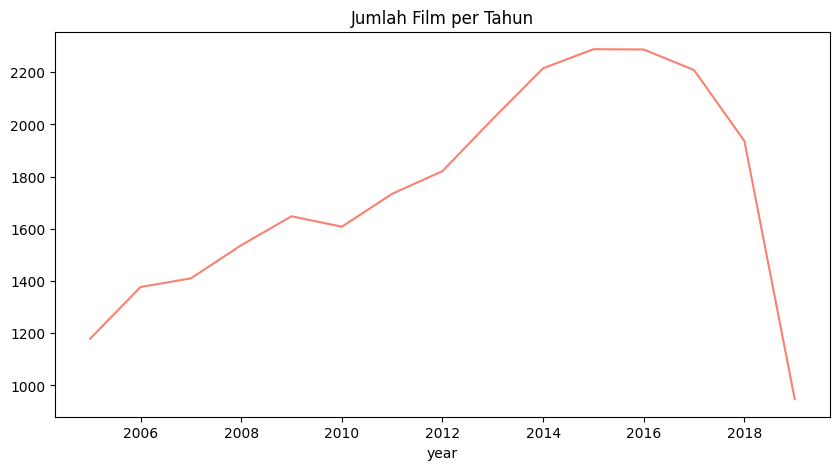

In [18]:
# film per tahunnya
df_movie_temp = df_movie.copy()
df_movie_temp['year'] = df_movie_temp['title'].str.extract(r'\((\d{4})\)').astype(float)
df_movie_temp['year'].dropna().astype(int).value_counts().sort_index().plot(figsize=(10,5), color='salmon', title='Jumlah Film per Tahun')

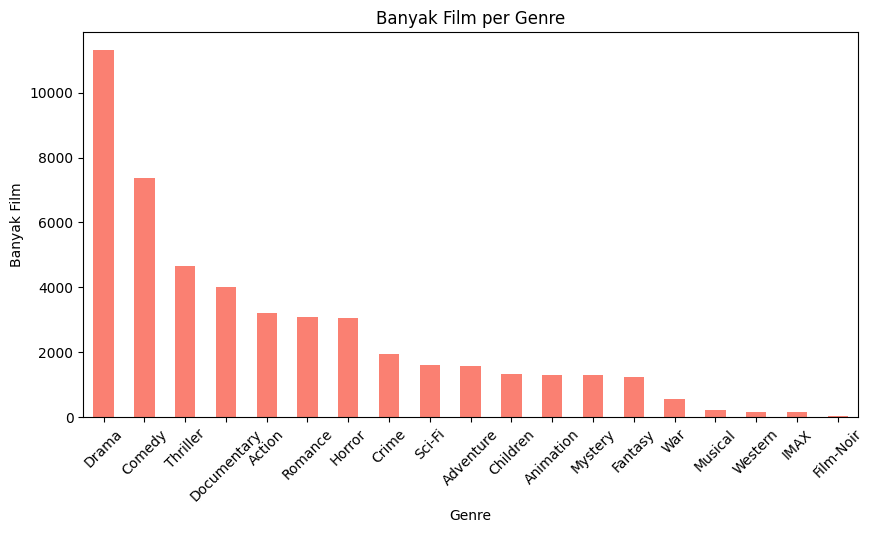

In [19]:
# menampilkan bamyak film per genre
genre_count = pd.Series([genre for genres_list in df_movie['genres'] for genre in genres_list]).value_counts()

plt.figure(figsize=(10, 5))
genre_count.plot(kind='bar', color='salmon')
plt.title('Banyak Film per Genre')
plt.xlabel('Genre')
plt.ylabel('Banyak Film')
plt.xticks(rotation=45)
plt.show()

#### df_rating

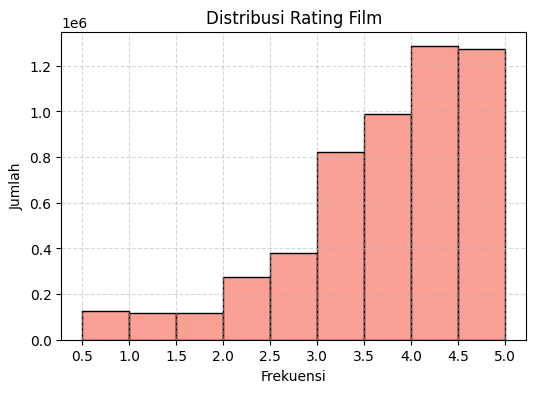

In [20]:
# histogram rating

plt.figure(figsize=(6,4))
sns.histplot(df_rating['rating'], bins=[0.5 + 0.5*i for i in range(10)], kde=False, color='salmon', edgecolor='black')
plt.title('Distribusi Rating Film')
plt.xlabel('Frekuensi')
plt.ylabel('Jumlah')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks([0.5 + 0.5*i for i in range(10)])
plt.show()

In [21]:
gc.collect()

5111

## Model Development Content Based Filtering

In [22]:
df = df_movie.copy()
df.sample(5)

,movieId,title,genres
41742,162356,Sniper: Ghost Shooter (2016),"[Action, Drama, War]"
15078,79802,Lion's Den (Leonera) (2008),[Drama]
16376,86626,Socialism (Film socialisme) (2010),[Drama]
54258,189167,A Dangerous Son (2018),[Documentary]
61577,206285,A Night of Horror Volume 1 (2015),"[Horror, Thriller]"


### Data Preparation

#### TF-IDF Vectorizer

In [23]:
# gabungkan genre jadi string per film
def preprocess_genres(genres):
    return [g.replace('-', '') for g in genres] # mengganti - menjadi _ seperti pada Sci-Fi menjadi Sci_Fi

df['genres_processed'] = df['genres'].apply(preprocess_genres)
df['genres_str'] = df['genres_processed'].apply(lambda x: ' '.join(x))

# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer()

# Melakukan perhitungan idf pada data genre
tfidf.fit(df['genres_str'])

# Mapping array dari fitur index integer ke fitur nama
tfidf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'filmnoir', 'horror', 'imax',
       'musical', 'mystery', 'romance', 'scifi', 'thriller', 'war',
       'western'], dtype=object)

In [24]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tfidf.fit_transform(df['genres_str'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(26362, 19)

In [25]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.44149015, 0.54306839, 0.        , ..., 0.3881674 , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.42439757, 0.        ,
         0.        ],
        ...,
        [0.62481528, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [26]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan jenis masakan
# Baris diisi dengan nama movie

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=df.title
).sample(22, axis=1, replace=True).sample(10, axis=0)

,horror,crime,war,western,documentary,fantasy,western,animation,western,romance,...,children,action,animation,drama,drama,comedy,drama,horror,fantasy,crime
title,,,,,,,,,,,,,,,,,,,,,
Haunt (2019),0.756353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.756353,0.0,0.0
Dominion: Prequel to the Exorcist (2005),0.756353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.756353,0.0,0.0
Innocent Saturday (2011),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,1.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.0
SampleThis (2013),0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Super Duper Alice Cooper (2014),0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Liberated: The New Sexual Revolution (2017),0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
The Chosen (2015),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Aleksandr's Price (2013),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.355269,0.355269,0.000000,0.355269,0.000000,0.0,0.0
H. (2014),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.367526,0.367526,0.000000,0.367526,0.000000,0.0,0.0


In [27]:
gc.collect()

3793

#### Cosine Similarity

In [28]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.7807726 , 0.        ,
        0.45527795],
       [0.        , 1.        , 0.55777999, ..., 0.27584979, 0.26250782,
        0.16541617],
       [0.        , 0.55777999, 1.        , ..., 0.        , 0.28700936,
        0.18085552],
       ...,
       [0.7807726 , 0.27584979, 0.        , ..., 1.        , 0.        ,
        0.35546855],
       [0.        , 0.26250782, 0.28700936, ..., 0.        , 1.        ,
        0.63013806],
       [0.45527795, 0.16541617, 0.18085552, ..., 0.35546855, 0.63013806,
        1.        ]])

In [29]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama movie
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['title'], columns=df['title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap movie
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (26362, 26362)


title,Duckweed (2017),On Probation (Tiempo de Valientes) (2005),The Healer (2017),Underdog Kids (2015),Race to Witch Mountain (2009)
title,,,,,
Live From New York! (2015),0.481207,0.366273,0.285246,0.000000,0.000000
Tactical Force (2011),0.297547,0.648365,0.176378,0.321671,0.151300
The Lightkeepers (2009),0.681859,0.312919,0.404188,0.000000,0.000000
Who We Are Now (2018),0.630138,0.000000,0.373529,0.000000,0.000000
Staying Vertical (2016),0.630138,0.000000,0.373529,0.000000,0.000000
Nerve (2013),0.263097,0.000000,0.155957,0.000000,0.000000
Hitting the Cycle (2012),0.630138,0.000000,0.373529,0.000000,0.000000
Mr. Socrates (2005),0.000000,0.526654,0.000000,0.401554,0.000000
Toys in the Attic (2009),0.000000,0.000000,0.428758,0.419774,0.642843


### Mendapatkan Rekomendasi

In [30]:
def movie_recommendations(title, similarity_data=cosine_sim_df, items=df[['title', 'genres']], k=5):

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_movie agar nama movie yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [31]:
df_movie[df_movie.title.eq('Death Kiss (2018)')]

,movieId,title,genres
56875,195123,Death Kiss (2018),"[Action, Thriller]"


In [32]:
# Mendapatkan rekomendasi movie yang mirip dengan Death Kiss (2018)
movie_recommendations('Death Kiss (2018)')

,title,genres
0,Hotel California (2008),"[Action, Thriller]"
1,HHhH (2017),"[Action, Thriller]"
2,Renegades (2017),"[Action, Thriller]"
3,Alleycats (2016),"[Action, Thriller]"
4,Daylight (Daglicht) (2013),"[Action, Thriller]"


## Model Development dengan Collaborative Filtering

In [33]:
df2 = df_rating.copy()
df2.sample(5)

,userId,movieId,rating
6176122,39983,91694,1.0
9086506,59199,61167,5.0
24234477,157531,45720,5.0
8304727,54075,33158,2.5
13976736,90587,50872,5.0


### Data Preparation

In [34]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df2['userId'].unique().tolist()

# Mengubah movieID menjadi list tanpa nilai yang sama
movie_ids = df2['movieId'].unique().tolist()

# Mendapatkan jumlah user
num_users = len(user_ids)
print(num_users)

# Mendapatkan jumlah movie
num_movie = len(movie_ids)
print(num_movie)

# Nilai minimum rating
min_rating = min(df2['rating'])

# Nilai maksimal rating
max_rating = max(df2['rating'])

print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

86240
27871
Number of User: 86240, Number of Movie: 27871, Min Rating: 0.5, Max Rating: 5.0


#### Membagi Data untuk Training dan Validasi

In [35]:
# Mengacak dataset
df2 = df2.sample(frac=1, random_state=42)
df2

,userId,movieId,rating
13958545,90485,92507,3.5
14185078,91911,99114,4.0
19210188,124656,79224,2.5
10384127,67360,164179,5.0
24990580,162508,49330,3.0
...,...,...,...
7204728,46692,92507,3.5
10283585,66693,81845,3.0
22816425,148270,46578,3.0
19991204,129999,88140,5.0


In [36]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = df2[['userId', 'movieId']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df2['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df2.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 90485  92507]
 [ 91911  99114]
 [124656  79224]
 ...
 [148270  46578]
 [129999  88140]
 [ 50579  68319]] [0.66666667 0.77777778 0.44444444 ... 0.55555556 1.         0.88888889]


### Proses Training

In [37]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [38]:
model = RecommenderNet(num_users, num_movie, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [39]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 128,
    epochs = 5,
    validation_data = (x_val, y_val)
)

Epoch 1/5
33676/33676 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - loss: 0.6663 - root_mean_squared_error: 0.2651 - val_loss: 0.6257 - val_root_mean_squared_error: 0.2257
Epoch 2/5
33676/33676 ━━━━━━━━━━━━━━━━━━━━ 128s 4ms/step - loss: 0.6225 - root_mean_squared_error: 0.2226 - val_loss: 0.6239 - val_root_mean_squared_error: 0.2237
Epoch 3/5
33676/33676 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - loss: 0.6238 - root_mean_squared_error: 0.2236 - val_loss: 0.6348 - val_root_mean_squared_error: 0.2321
Epoch 4/5
33676/33676 ━━━━━━━━━━━━━━━━━━━━ 146s 4ms/step - loss: 0.6342 - root_mean_squared_error: 0.2314 - val_loss: 0.6308 - val_root_mean_squared_error: 0.2291
Epoch 5/5
33676/33676 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - loss: 0.6299 - root_mean_squared_error: 0.2281 - val_loss: 0.6328 - val_root_mean_squared_error: 0.2305


### Visualisasi Metrik

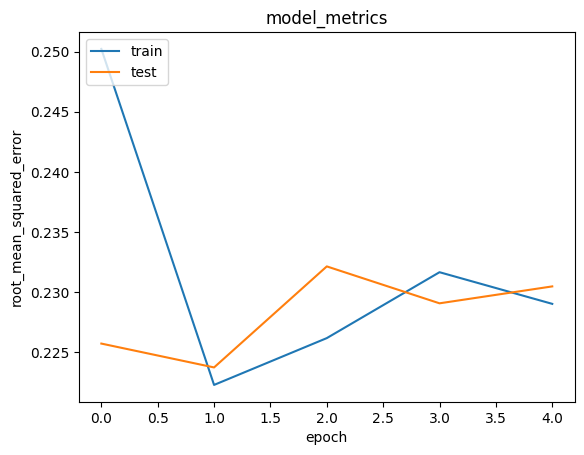

In [40]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Mendapatkan Rekomendasi

In [41]:
movie_df = df.copy()
rating_df = df2.copy()

# Mengambil sample user
user_id = df2.userId.sample(1).iloc[0]
movie_watched_by_user = df2[df2.userId == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
movie_not_watched = movie_df[~movie_df['movieId'].isin(movie_watched_by_user.movieId.values)]['movieId']

user_movie_array = np.hstack((
    np.array([[user_id]] * len(movie_not_watched)),
    np.array(movie_not_watched).reshape(-1, 1)
))

In [42]:
ratings = model.predict(user_movie_array).flatten()

# Ambil indeks dengan prediksi rating tertinggi
top_ratings_indices = ratings.argsort()[-10:][::-1]

# Karena kita pakai ID asli, ambil langsung dari movie_not_watched
recommended_movie_ids = [movie_not_watched.iloc[x] for x in top_ratings_indices]

print('Showing recommendations for user:', user_id)
print('===' * 9)
print('Film with high ratings from user')
print('----' * 8)

# Ambil 5 film dengan rating tertinggi dari user tersebut
top_movie_user = (
    movie_watched_by_user.sort_values(
        by='rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

# Tampilkan film yang sudah pernah ditonton dan disukai user
movie_df_rows = movie_df[movie_df['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ':', row.genres)

print('----' * 8)
print('Top 10 film recommendation')
print('----' * 8)

# Tampilkan film hasil rekomendasi model
recommended_movie = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genres)

815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Showing recommendations for user: 3959
Film with high ratings from user
--------------------------------
Hunt, The (Jagten) (2012) : ['Drama']
Winter Sleep (Kis Uykusu) (2014) : ['Drama']
Ex Machina (2015) : ['Drama', 'Sci-Fi', 'Thriller']
The Jinx: The Life and Deaths of Robert Durst (2015) : ['Documentary']
--------------------------------
Top 10 film recommendation
--------------------------------
Girl from Monday, The (2005) : ['Action', 'Comedy', 'Sci-Fi']
Miss Congeniality 2: Armed and Fabulous (2005) : ['Adventure', 'Comedy', 'Crime']
Guess Who (2005) : ['Comedy', 'Romance']
Ballad of Jack and Rose, The (2005) : ['Drama']
Beauty Shop (2005) : ['Comedy']
Dust to Glory (2005) : ['Action', 'Adventure', 'Documentary']
Sahara (2005) : ['Action', 'Adventure', 'Comedy']
Fever Pitch (2005) : ['Comedy', 'Romance']
We (2018) : ['Drama']
Bad Poems (2018) : ['Comedy', 'Drama']
